# **RECOMPRA EM E-COMMERCE: LIGHT GBM**



### Instalação de bibliotecas

In [ ]:
# Apenas a biblioteca shap precisa ser instalada; as demais utilizadas neste notebook já vêm pré-instaladas no Google Colab
! pip install shap

### Carregamento de bibliotecas

In [ ]:
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb                                         # Light GBM
from sklearn.model_selection import KFold, cross_validate      # Validação cruzada
from sklearn.model_selection import GridSearchCV               # Otimização de hiperparâmetros via grid search
from sklearn.model_selection import RandomizedSearchCV         # Otimização de hiperparâmetros via random search
import shap                                                    # Interpretabilidade de modelos de ML

### Leitura da base de dados

In [ ]:
dados_ecommerce = pd.read_table("Recompra_eCommerce.txt", sep = "\t")

### Visualização da base de dados

In [ ]:
display(dados_ecommerce)

,ID_CLIENTE,IDADE,VALOR_COMPRA_SITE,QTDE_ITENS_COMPRA_SITE,FLAG_ACESSORIOS_COMPRA_SITE,FLAG_FEMININA_COMPRA_SITE,FLAG_MASCULINA_COMPRA_SITE,NOTA_SATISF_COMPRA_SITE,FLAG_COMPROU_LOJA_FISICA_6M,QTDE_COMPRAS_LOJA_FISICA_6M,QTDE_ITENS_LOJA_FISICA_6M,FLAG_RECOMPRA_PROX_3_MESES
0,1,29,185.5,2,0,1,0,7,1,4,4,1
1,2,27,215.5,2,0,1,1,7,1,2,2,1
2,3,29,106.4,4,0,1,0,10,1,1,5,1
3,4,18,140.2,1,0,1,0,8,1,1,4,0
4,5,24,72.9,2,0,1,0,7,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1269,1270,40,165.9,6,0,1,0,8,1,3,9,1
1270,1271,33,55.6,1,0,1,0,9,0,0,0,0
1271,1272,28,105.7,4,0,0,1,6,0,0,0,0
1272,1273,28,284.9,3,0,1,1,8,0,0,0,0


### Separação de features e target

In [ ]:
X = dados_ecommerce.drop(columns = ['FLAG_RECOMPRA_PROX_3_MESES', 'ID_CLIENTE'])
y = dados_ecommerce['FLAG_RECOMPRA_PROX_3_MESES']

### Criação de colunas dummy para variáveis explicativas qualitativas

In [ ]:
# Não necessário para esta base de dados, pois todas as variáveis explicativas são quantitativas

### Modelo 1: Light GBM com otimização de hiperparâmetros via validação cruzada, com grid search

In [ ]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [2, 3, 5, 10],
    'min_data_in_leaf': [10, 20, 50, 100]
}

In [ ]:
# Busca da melhor combinação de hiperparâmetros, via validação cruzada com grid search, com otimização de AUC e k = 10
lightgbm = lgb.LGBMClassifier(verbose = -1, random_state = 123)
cv = KFold(n_splits = 10, shuffle = True, random_state = 123)
scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
grid_search = GridSearchCV(lightgbm, param_grid, cv = cv, scoring = scoring, refit = 'AUC')
grid_search.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=LGBMClassifier(random_state=123, verbose=-1),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'max_depth': [2, 3, 5, 10],
                         'min_data_in_leaf': [10, 20, 50, 100],
                         'n_estimators': [10, 50, 100, 200]},
             refit='AUC',
             scoring={'AUC': 'roc_auc',
                      'balanced_accuracy': 'balanced_accuracy',
                      'recall': 'recall'})

In [ ]:
# Melhor configuração de hiperparâmetros identificada
print(grid_search.best_params_)

{'learning_rate': 0.5, 'max_depth': 5, 'min_data_in_leaf': 100, 'n_estimators': 10}


In [ ]:
# Tabela de desempenho com todas as combinações de hiperparâmetros testadas, ordenadas do maior para o menor AUC médio nos conjuntos de teste
resultados_grid = pd.DataFrame(grid_search.cv_results_)
resultados_grid = resultados_grid[['params',
                                   'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC',
                                   'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy',
                                   'mean_test_recall', 'std_test_recall', 'rank_test_recall']].sort_values(by = 'rank_test_AUC')
resultados_grid

,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_balanced_accuracy,std_test_balanced_accuracy,rank_test_balanced_accuracy,mean_test_recall,std_test_recall,rank_test_recall
236,"{'learning_rate': 0.5, 'max_depth': 5, 'min_da...",0.906241,0.026727,1,0.829801,0.028057,28,0.861047,0.045905,128
162,"{'learning_rate': 0.1, 'max_depth': 5, 'min_da...",0.905474,0.021678,2,0.829030,0.027012,36,0.848892,0.048986,165
99,"{'learning_rate': 0.05, 'max_depth': 5, 'min_d...",0.905328,0.021950,3,0.828561,0.036224,43,0.844579,0.050984,182
98,"{'learning_rate': 0.05, 'max_depth': 5, 'min_d...",0.905305,0.021315,4,0.822995,0.028732,99,0.852948,0.037305,153
161,"{'learning_rate': 0.1, 'max_depth': 5, 'min_da...",0.904927,0.022110,5,0.829312,0.026362,35,0.856126,0.042016,146
...,...,...,...,...,...,...,...,...,...,...
76,"{'learning_rate': 0.05, 'max_depth': 2, 'min_d...",0.855951,0.024227,252,0.766514,0.031791,247,0.946281,0.024162,8
4,"{'learning_rate': 0.01, 'max_depth': 2, 'min_d...",0.853929,0.025675,253,0.766563,0.031809,240,0.947894,0.023924,1
8,"{'learning_rate': 0.01, 'max_depth': 2, 'min_d...",0.853929,0.025675,253,0.766563,0.031809,240,0.947894,0.023924,1
0,"{'learning_rate': 0.01, 'max_depth': 2, 'min_d...",0.853929,0.025675,253,0.766563,0.031809,240,0.947894,0.023924,1


In [ ]:
# Modelo final a partir da melhor combinação de hiperparâmetros
lightgbm_1 = grid_search.best_estimator_

### Modelo 2: Light GBM com otimização de hiperparâmetros via validação cruzada, com random search

In [ ]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': np.arange(10, 201, 10),
    'learning_rate': np.arange(0.01, 0.51, 0.01),
    'max_depth': np.arange(2, 11),
    'min_data_in_leaf': np.arange(10, 101)
}

In [ ]:
# Busca da melhor combinação de hiperparâmetros, via validação cruzada com random search, com otimização de AUC e k = 10
lightgbm = lgb.LGBMClassifier(verbose = -1, random_state = 123)
cv = KFold(n_splits = 10, shuffle = True, random_state = 123)
scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
random_search = RandomizedSearchCV(lightgbm, param_grid, cv = cv, scoring = scoring, refit = 'AUC', n_iter = 50, random_state = 123)
random_search.fit(X, y)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=LGBMClassifier(random_state=123, verbose=-1),
                   n_iter=50,
                   param_distributions={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35...
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])},
                   random_state=123, refit='AUC',
                   scoring={'AUC': 'roc_auc',
                            'balanced_accuracy': 'balanced_accuracy',
                            'recall': 'recall'})

In [ ]:
# Melhor configuração de hiperparâmetros identificada
print(random_search.best_params_)

{'n_estimators': 20, 'min_data_in_leaf': 64, 'max_depth': 7, 'learning_rate': 0.24000000000000002}


In [ ]:
# Tabela com todas as combinações de hiperparâmetros testadas, ordenadas do maior para o menor AUC médio nos conjuntos de teste
resultados_grid = pd.DataFrame(random_search.cv_results_)
resultados_grid = resultados_grid[['params',
                                   'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC',
                                   'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy',
                                   'mean_test_recall', 'std_test_recall', 'rank_test_recall']].sort_values(by = 'rank_test_AUC')
resultados_grid

,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_balanced_accuracy,std_test_balanced_accuracy,rank_test_balanced_accuracy,mean_test_recall,std_test_recall,rank_test_recall
37,"{'n_estimators': 20, 'min_data_in_leaf': 64, '...",0.903660,0.023451,1,0.827080,0.037344,6,0.861920,0.052235,7
30,"{'n_estimators': 70, 'min_data_in_leaf': 86, '...",0.903243,0.024064,2,0.826146,0.024292,7,0.861199,0.035447,8
36,"{'n_estimators': 80, 'min_data_in_leaf': 75, '...",0.903216,0.022392,3,0.824181,0.031060,15,0.851192,0.049211,15
20,"{'n_estimators': 40, 'min_data_in_leaf': 83, '...",0.903158,0.023207,4,0.827120,0.025131,5,0.861172,0.042396,9
41,"{'n_estimators': 50, 'min_data_in_leaf': 83, '...",0.903005,0.022727,5,0.832391,0.033285,2,0.872704,0.043852,3
11,"{'n_estimators': 130, 'min_data_in_leaf': 15, ...",0.902461,0.022341,6,0.833198,0.027305,1,0.877750,0.036910,2
1,"{'n_estimators': 100, 'min_data_in_leaf': 71, ...",0.900758,0.022182,7,0.821706,0.032013,18,0.842080,0.046273,20
16,"{'n_estimators': 110, 'min_data_in_leaf': 65, ...",0.900536,0.023625,8,0.818408,0.032858,26,0.849858,0.042774,16
4,"{'n_estimators': 170, 'min_data_in_leaf': 78, ...",0.900382,0.022729,9,0.819422,0.027266,25,0.837884,0.043726,28
12,"{'n_estimators': 60, 'min_data_in_leaf': 55, '...",0.900282,0.021392,10,0.814784,0.033239,37,0.836640,0.042509,31


In [ ]:
# Modelo final a partir da melhor combinação de hiperparâmetros
lightgbm_2 = random_search.best_estimator_

### Estimativa de desempenho do modelo 1 em dados totalmente apartados, via validação cruzada aninhada

In [ ]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [2, 3, 5, 10],
    'min_data_in_leaf': [10, 20, 50, 100]
}

In [ ]:
# Validação cruzada aninhada com grid search e otimização de AUC, k1 = 3 e k2 = 5
lightgbm = lgb.LGBMClassifier(verbose = -1, random_state = 123)
inner_cv = KFold(n_splits = 3, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
grid_search = GridSearchCV(lightgbm, param_grid, cv = inner_cv, scoring = scoring, refit = 'AUC')
nested_scores = cross_validate(grid_search, X = X, y = y, cv = outer_cv, scoring = scoring)

In [ ]:
# AUC das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_AUC'].round(3))
print("Média de AUC: " + str(round(np.mean(nested_scores['test_AUC']), 3)))
print("D.P. de AUC: " + str(round(np.std(nested_scores['test_AUC']), 3)))

[0.889 0.897 0.915 0.9   0.92 ]
Média de AUC: 0.904
D.P. de AUC: 0.012


In [ ]:
# Acurácia balanceada das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_balanced_accuracy'].round(3))
print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))

[0.811 0.815 0.853 0.827 0.85 ]
Média de Acurácia Balanceada: 0.831
D.P. de Acurácia Balanceada: 0.017


In [ ]:
# Sensibilidade das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_recall'].round(3))
print("Média de Sensibilidade: " + str(round(np.mean(nested_scores['test_recall']), 3)))
print("D.P. de Sensibilidade: " + str(round(np.std(nested_scores['test_recall']), 3)))

[0.838 0.858 0.883 0.896 0.891]
Média de Sensibilidade: 0.873
D.P. de Sensibilidade: 0.022


### Estimativa de desempenho do modelo 2 em dados totalmente apartados, via validação cruzada aninhada

In [ ]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': np.arange(10, 201, 10),
    'learning_rate': np.arange(0.01, 0.51, 0.01),
    'max_depth': np.arange(2, 11),
    'min_data_in_leaf': np.arange(10, 101)
}

In [ ]:
# Validação cruzada aninhada com random search e otimização de AUC, k1 = 3 e k2 = 5
lightgbm = lgb.LGBMClassifier(verbose = -1, random_state = 123)
inner_cv = KFold(n_splits = 3, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
random_search = RandomizedSearchCV(lightgbm, param_grid, cv = inner_cv, scoring = scoring, refit = 'AUC', n_iter = 50, random_state = 123)
nested_scores = cross_validate(random_search, X = X, y = y, cv = outer_cv, scoring = scoring)

In [ ]:
# AUC das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_AUC'].round(3))
print("Média de AUC: " + str(round(np.mean(nested_scores['test_AUC']), 3)))
print("D.P. de AUC: " + str(round(np.std(nested_scores['test_AUC']), 3)))

[0.89  0.895 0.915 0.903 0.926]
Média de AUC: 0.906
D.P. de AUC: 0.013


In [ ]:
# Acurácia balanceada das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_balanced_accuracy'].round(3))
print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))

[0.811 0.816 0.841 0.843 0.854]
Média de Acurácia Balanceada: 0.833
D.P. de Acurácia Balanceada: 0.017


In [ ]:
# Sensibilidade das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_recall'].round(3))
print("Média de Sensibilidade: " + str(round(np.mean(nested_scores['test_recall']), 3)))
print("D.P. de Sensibilidade: " + str(round(np.std(nested_scores['test_recall']), 3)))

[0.838 0.851 0.869 0.911 0.898]
Média de Sensibilidade: 0.874
D.P. de Sensibilidade: 0.028


### Aplicação do modelo final de Light GBM na base de dados



In [ ]:
# Aplicação do modelo (cálculo das probabilidades preditas)
y_prob = lightgbm_1.predict_proba(X)[:,1]

In [ ]:
# Definição de ponto de corte
ponto_corte = y.astype(int).mean()

In [ ]:
# Atribuição da categoria predita
dados_ecommerce['y_pred'] = (y_prob >= ponto_corte).astype(int)

### Importância das features do modelo final

In [ ]:
# Cálculo de medida de importância de Gini
importancias = lightgbm_1.feature_importances_
features = X.columns

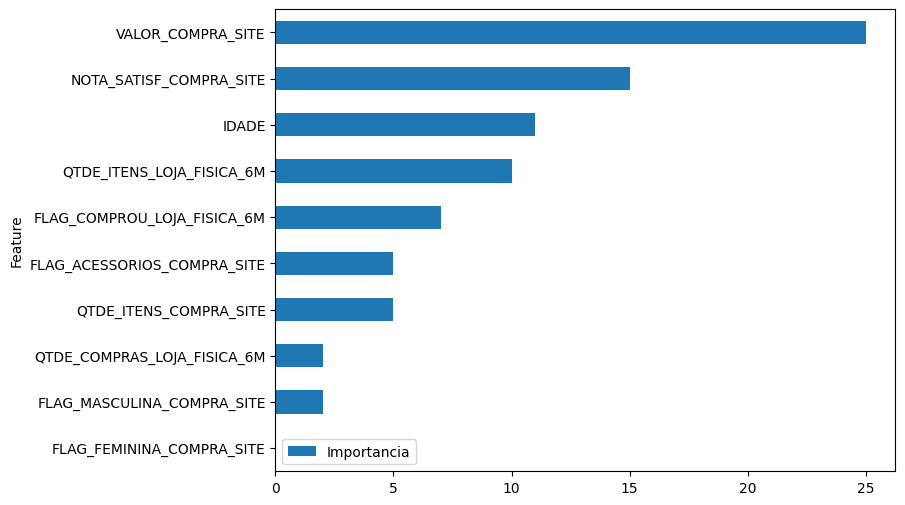

In [ ]:
# Gráfico das importâncias de Gini
df_importancias = pd.DataFrame({'Feature': features, 'Importancia': importancias}).sort_values(by = 'Importancia', ascending = True)
df_importancias.plot.barh(x = 'Feature', y = 'Importancia', figsize = (8, 6))
plt.show()

In [ ]:
# Cálculo de valores SHAP para as observações
explainer = shap.Explainer(lightgbm_1)
valores_shap = explainer(X)

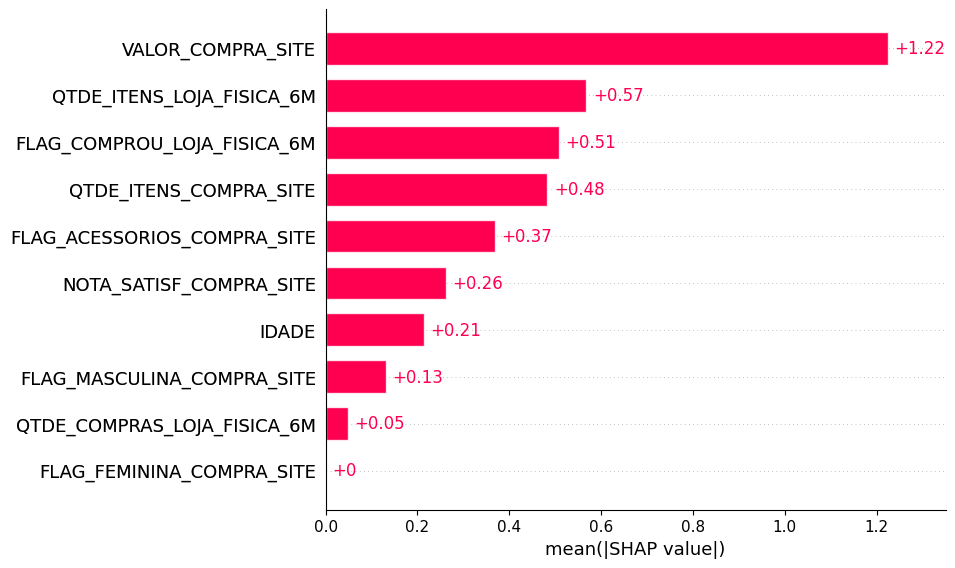

In [ ]:
# Gráfico do SHAP absoluto médio por feature
shap.plots.bar(valores_shap)

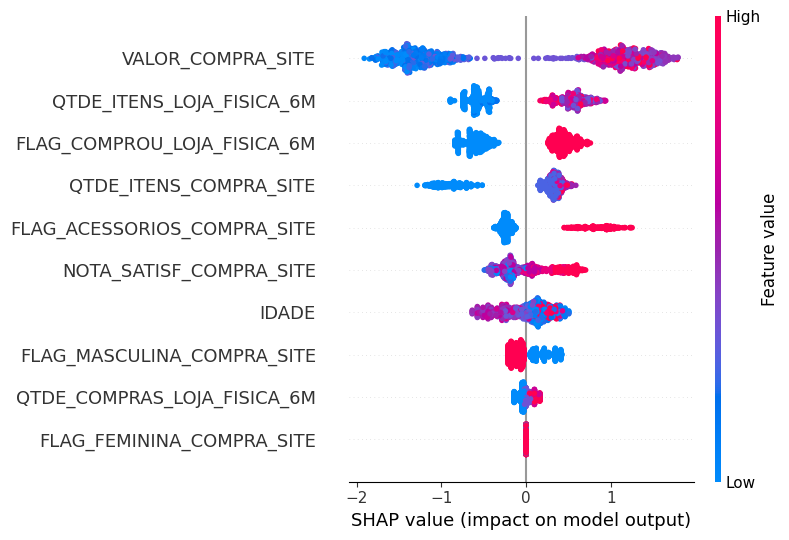

In [ ]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot)
shap.summary_plot(valores_shap)